In [6]:
import keras
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import binary_crossentropy
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt

In [7]:
# MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()

x_train = np.reshape(x_train, [60000, 784])
x_test = np.reshape(x_test, [10000, 784])
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=(784, ), name='encoder_input')
x = Dense(512, activation='relu')(inputs)
z_mean = Dense(2, name='z_mean')(x)
z_log_var = Dense(2, name='z_log_var')(x)
z = Lambda(sampling, output_shape=(2,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
# build decoder model
latent_inputs = Input(shape=(2,), name='z_sampling')
x = Dense(512, activation='relu')(latent_inputs)
outputs = Dense(784, activation='sigmoid')(x)
# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

In [ ]:
# VAE loss = mse_loss or xent_loss + kl_loss
reconstruction_loss = binary_crossentropy(inputs, outputs) * 784

kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)*(-0.5)

vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [8]:
# train the autoencoder
vae.fit(x_train,
        epochs=50,
        batch_size=128,
        validation_data=(x_test, None))

/usr/local/lib/python3.6/dist-packages/keras/engine/training_utils.py:819: UserWarning: Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 14s 232us/step - loss: 198.9698 - val_loss: 174.0658
Epoch 2/50
60000/60000 [==============================] - 13s 223us/step - loss: 170.7867 - val_loss: 167.3984
Epoch 3/50
60000/60000 [==============================] - 13s 222us/step - loss: 165.6201 - val_loss: 163.3487
Epoch 4/50
60000/60000 [==============================] - 13s 223us/step - loss: 162.2058 - val_loss: 160.6898
Epoch 5/50
60000/60000 [==============================] - 13s 223us/step - loss: 160.0699 - val_loss: 159.2391
Epoch 6/50
60000/60000 [==============================] - 13s 224us/step - loss: 158.5908 - val_loss: 158.0246
Epoch 7/50
60000/60000 [==============================] - 13s 222us/step - loss: 157.4262 - val_loss: 157.4132
Epoch 8/50
60000/60000 [==============================] - 13s 220us/step - loss: 156.5384 - val_loss: 156.3530
Epoch 9/50
60000/60000 [==============================] - 13s 

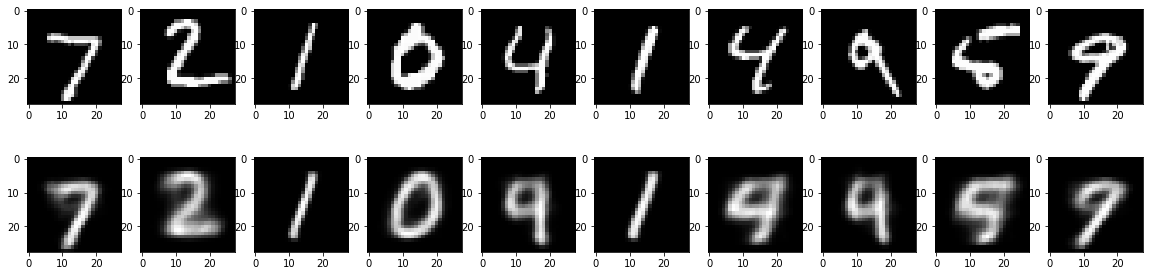

In [13]:
x_test_predicted = vae.predict(x_test)

n=10
plt.figure(figsize=(20,5))
for i in range(n):
  #original
  plt.subplot(2,n,i+1)
  plt.imshow(x_test[i].reshape(28,28))
  plt.gray()

  #reconstructed
  plt.subplot(2,n,i+1+n)
  plt.imshow(x_test_predicted[i].reshape(28,28))
  plt.gray()